notebook for training the NN
- labels and training images as individual images in distinct directories
- will (maybe) be able to batch load them

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import torch
import torch.nn.functional as F
from pathlib import Path
import textwrap
import matplotlib.pyplot as plt

from datetime import datetime
import os
import warnings
warnings.filterwarnings("ignore", module="torch.nn.functional")

import sys
sys.path.append("/zota/Lorentz/AlecBender/mumax_training_files/SkyrmNet-main/hipl-main")
from image_helpers import * 
 
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.filters import threshold_triangle


from SkyrmNet import *

if torch.cuda.is_available():
    gpu = 3 #choose desired gpu here
    print(f"There are {torch.cuda.device_count()} GPUs available")
    print(f"Running on GPU (index) {gpu}")
else:
    print("GPU is not available")
    
today = datetime.today().strftime('%y%m%d')

There are 4 GPUs available
Running on GPU (index) 3


In [ ]:
today = datetime.today().strftime('%y%m%d')
today = today+"_skyrm12_10000_v2"

In [ ]:
NN_name = f"SkyrmNet_{today}"
savedir = Path(f'./trained_SkyrmNet/{today}').resolve() # dir to save results
savedir.mkdir(exist_ok=False)

#### If loading a NN

In [3]:
# load desired NN
nn_path = "/home/bendera/Lorentz_folder/AlecBender/mumax_training_files/SkyrmNet-main/trained_SkyrmNet/220708_skyrm12_10000_v2/SkyrmNet_220708_skyrm12_10000_v2_best.pt"
model = SkyrmNet(nb_classes=2)
model.cuda(gpu)
model.load_state_dict(torch.load(nn_path))
model.eval()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # lr is a learniing rate

## Load training data
- v1 of this is going to just load everything into big stacks of training and label data
- v2 will be able to batch load 

In [ ]:
training_dir = Path("/zota/Lorentz/AlecBender/mumax_training_files/SkyrmNet_training12"
                    ).expanduser().resolve()

In [ ]:
# turns images into a numpy array
def load_directory(path, num_images=None, start_index=None): 
    ni = num_images  # will be number of images to load 
    si = start_index # in preparation for batch loading
    
    path = Path(path)
    imfiles = list(path.glob("*.tif"))
    imfiles.sort()
    images = []
    for file in imfiles: 
        images.append(io.imread(file))
    
    return np.array(images)

In [ ]:
test_split = 0.2 # ratio of images used for testing
batch_size = 64 # total number of training images present in a single batch
epochs = 500 # one complete pass of the training dataset through the NN

images_load_all = load_directory(training_dir / "training_images")
labels_load_all = load_directory(training_dir / "label_images")

assert images_load_all.shape[0] == labels_load_all.shape[0]
print(f"Total size Images, Labels:\n {images_load_all.shape}, {labels_load_all.shape}")
print(f"Number training images: {int(images_load_all.shape[0]*(1-test_split))}")
print(f"Number test images: {int(images_load_all.shape[0]*(test_split))}")

# Apply noise to training data

### Extend training data by tiling if not enough training data is present

In [ ]:
'''
plt.close('all')
show_im(images_load_all[0])
show_im(images_load_all[1])
show_im(images_load_all[2])
'''

# If creating additional images from dataset

In [ ]:
extend_factor = 8
images_extra = np.tile(images_load_all, (extend_factor,1,1))
labels_extra = np.tile(labels_load_all, (extend_factor,1,1))

print(images_extra.shape)

norder = np.arange(images_extra.shape[0])
np.random.shuffle(norder)
images_extra = np.array([images_extra[i] for i in norder])
labels_extra = np.array([labels_extra[i] for i in norder])

# For a single class case, we still need to explicitly specify the single channel
labels_extra2 = labels_extra[..., None] if np.ndim(labels_extra) == 3 else labels_extra
# Number of channels in masked data (the training images have a single channel)
ch = labels_extra2.shape[-1]


## Add noise

In [ ]:
from datatransform import training_log, datatransform

In [ ]:
# Define image distortion/noise parameters

zoom = False  # zoom factor

# caused by uncertainty associated with the measurement of light -- photon detections
# appears as grain like-appearences 
poisson = [15,35]  # P noise range (scaled units)

# caused by poor illumination, high temperature, and/or transmission
# appears as white noise
gauss = [40, 200]  # G noise range (scaled units)

# blur is most often caused by missed focus
# makes the color transition smooth rather than sudden
blur = [1, 150]  # Blurring range (scaled units)

# the difference in brightness between light and dark areas of an image
# contrast determines the number of shades in the image
contrast = [6, 16]  # contrast range (< 10 is brighter, > 10 is darker)

# errors in data transfer cause this form of noise to appear
# appears as white and black pixels that appear at random intervals
salt_and_pepper = [5, 35]  # min/max amount of salted/peppered pixels (scaled units)

notes = textwrap.dedent(
    """Trained on rotated Skx data such that tilt axis is along x axis
    (contrast is left/right)
    """
)

dim_order_in = "channel_last"
dim_order_out = "channel_first"
seed = 42
zoom = False
rotation = False

# run the augmentor
imaug = datatransform(
    n_channels=ch,
    dim_order_in=dim_order_in,
    dim_order_out=dim_order_out,
    gauss_noise=gauss,
    poisson_noise=poisson,
    salt_and_pepper=salt_and_pepper,
    contrast=contrast,
    blur=blur,
    zoom=zoom,
    rotation=rotation,
    seed=seed,
    squeeze_channels=True,
    classifier=True,
)

images_noise, labels_noise = imaug.run(images_extra, labels_extra2)

training_log(
    NN_name,
    savedir,
    images_shape=images_extra.shape,
    labels_shape=labels_extra2.shape,
    test_split=test_split,
    batch_size=batch_size,
    epochs=epochs,
    n_channels=ch,
    dim_order_in=dim_order_in,
    dim_order_out=dim_order_out,
    gauss_noise=gauss,
    poisson_noise=poisson,
    salt_and_pepper=salt_and_pepper,
    contrast=contrast,
    blur=blur,
    zoom=zoom,
    rotation=rotation,
    seed=seed,
    notes=notes,
)

labels_noise = labels_noise.squeeze()
print(images_noise.shape, labels_noise.shape)



In [ ]:
from datatransform import training_log, datatransform

### Look at some of the augmented data

In [ ]:
s = 30
n = 5

n = n + 1
fig = plt.figure( figsize=(15, 8))
for i in range(1, n):   
    ax = fig.add_subplot(3, n, i)
    ax.imshow(images_extra[i+s-1], cmap='gray')
    ax.set_title("Original image" + str(i-1), fontsize=10)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  
    if i != 1: 
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)  
        
    ax = fig.add_subplot(3, n, i+n)
    ax.imshow(images_noise[i+s-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i-1), fontsize=10)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)    
    if i != 1: 
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)  
    
    ax = fig.add_subplot(3, n, i+2*n)
    ax.imshow(labels_noise[i+s-1], cmap='jet', interpolation='Gaussian')
#     ax.imshow(images_noise[i+s-1,0,:,:], cmap='gray', alpha=0.5)
    
    
    ax.set_title('Ground truth ' + str(i), fontsize=10)
    if i != 1: 
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)  

fig.tight_layout()
# plt.savefig("/zota/Lorentz/Arthur/misc/NN_UIUC/outputs_211008/augmented_data.png", dpi=800, bbox_inches="tight")
plt.show()

# If using only orginal dataset

In [ ]:
norder = np.arange(images_load_all.shape[0])
np.random.shuffle(norder)
images_load_all = np.array([images_load_all[i] for i in norder])
labels_load_all = np.array([labels_load_all[i] for i in norder])

# For a single class case, we still need to explicitly specify the single channel
labels_load_all2 = labels_load_all[..., None] if np.ndim(labels_load_all) == 3 else labels_load_all
# Number of channels in masked data (the training images have a single channel)
ch = labels_load_all2.shape[-1]

## add noise

In [ ]:
from datatransform import training_log, datatransform

In [ ]:
# Define image distortion/noise parameters

zoom = False  # zoom factor

# caused by uncertainty associated with the measurement of light -- photon detections
# appears as grain like-appearences 
poisson = [15, 35]  # P noise range (scaled units)

# caused by poor illumination, high temperature, and/or transmission
# appears as white noise
gauss = [40, 200]  # G noise range (scaled units)

# blur is most often caused by missed focus
# makes the color transition smooth rather than sudden
blur = [1, 150]  # Blurring range (scaled units)

# the difference in brightness between light and dark areas of an image
# contrast determines the number of shades in the image
contrast = [6, 16]  # contrast range (< 10 is brighter, > 10 is darker)

# errors in data transfer cause this form of noise to appear
# appears as white and black pixels that appear at random intervals
salt_and_pepper = [5, 35]  # min/max amount of salted/peppered pixels (scaled units)

notes = textwrap.dedent(
    """Trained on rotated Skx data such that tilt axis is along x axis
    (contrast is left/right)
    """
    
)

dim_order_in = "channel_last"
dim_order_out = "channel_first"
seed = 42
zoom = False
rotation = False

# run the augmentor
imaug = datatransform(
    n_channels=ch,
    dim_order_in=dim_order_in,
    dim_order_out=dim_order_out,
    gauss_noise=gauss,
    poisson_noise=poisson,
    salt_and_pepper=salt_and_pepper,
    contrast=contrast,
    blur=blur,
    zoom=zoom,
    rotation=rotation,
    seed=seed,
    squeeze_channels=True,
    classifier=True,
)

images_noise, labels_noise = imaug.run(images_load_all, labels_load_all2)

training_log(
    NN_name,
    savedir,
    images_shape=images_load_all.shape,
    labels_shape=labels_load_all2.shape,
    test_split=test_split,
    batch_size=batch_size,
    epochs=epochs,
    n_channels=ch,
    dim_order_in=dim_order_in,
    dim_order_out=dim_order_out,
    gauss_noise=gauss,
    poisson_noise=poisson,
    salt_and_pepper=salt_and_pepper,
    contrast=contrast,
    blur=blur,
    zoom=zoom,
    rotation=rotation,
    seed=seed,
    notes=notes,
)

labels_noise = labels_noise.squeeze()
print(images_noise.shape, labels_noise.shape)



In [ ]:
from datatransform import training_log, datatransform

### Look at some of the augmented data

In [ ]:
s=30
n = 5

n = n + 1
fig = plt.figure( figsize=(15, 8))
for i in range(1, n):   
    ax = fig.add_subplot(3, n, i)
    ax.imshow(images_load_all[i+s-1], cmap='gray')
    ax.set_title("Original image" + str(i-1), fontsize=10)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  
    if i != 1: 
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)  
        
    ax = fig.add_subplot(3, n, i+n)
    ax.imshow(images_noise[i+s-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i-1), fontsize=10)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)    
    if i != 1: 
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)  
    
    ax = fig.add_subplot(3, n, i+2*n)
    ax.imshow(labels_noise[i+s-1], cmap='jet', interpolation='Gaussian')
#     ax.imshow(images_noise[i+s-1,0,:,:], cmap='gray', alpha=0.5)
    
    
    ax.set_title('Ground truth ' + str(i), fontsize=10)
    if i != 1: 
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)  

fig.tight_layout()
# plt.savefig("/zota/Lorentz/Arthur/misc/NN_UIUC/outputs_211008/augmented_data.png", dpi=800, bbox_inches="tight")
plt.show()

# initialize and train a new CNN

In [ ]:
# images_train, images_test, labels_train, labels_test = train_test_split(
#     images_load_all, 
#     labels_load_all,
#     test_size=test_split)
# images_train = np.expand_dims(images_train_batch, 1)
# images_test = np.expand_dims(images_test_batch, 1)


images_train, images_test, labels_train, labels_test = train_test_split(
    images_noise, 
    labels_noise,
    test_size=test_split)
print(images_train.shape, labels_train.shape, images_test.shape, labels_test.shape)

In [ ]:
rng_seed(42) # for reproducibility

# Initialize a model
model = SkyrmNet(nb_classes=2)
model.cuda(gpu)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [ ]:
n_train_batches, _ = np.divmod(labels_train.shape[0], batch_size)
n_test_batches, _ = np.divmod(labels_test.shape[0], batch_size)
images_train_batch = np.split(
    images_train[:n_train_batches*batch_size], n_train_batches)
labels_train_batch = np.split(
    labels_train[:n_train_batches*batch_size], n_train_batches)
images_test_batch = np.split(
    images_test[:n_test_batches*batch_size], n_test_batches)
labels_test_batch = np.split(
    labels_test[:n_test_batches*batch_size], n_test_batches)
print('loaded stack shape: ', np.shape(images_train))
print('train batch image shape: ', np.shape(images_train_batch))
print('test batch image shape: ', np.shape(images_test_batch))
print('train batch label shape: ', np.shape(labels_train_batch))
print('test batch label shape: ', np.shape(labels_test_batch))

### Train

In [ ]:
print_loss = 50 # print loss every m-th epoch.
epsilon = 0.01
# Generate sequence of random numbers for batch selection during training/testing
batch_ridx = [np.random.randint(0, len(images_train_batch)) for _ in range(epochs)]
batch_ridx_t = [np.random.randint(0, len(images_test_batch)) for _ in range(epochs)]
# Start training
train_losses, test_losses = [], []
prev_10_test_loss = None
for e in range(epochs):  
    model.train() # put in training mode 
    # Generate batch of training images with corresponding ground truth
    images = images_train_batch[batch_ridx[e]]
    labels = labels_train_batch[batch_ridx[e]]
    # Transform images and ground truth to torch tensors and move to GPU
    images = torch.from_numpy(images).float()
    labels = torch.from_numpy(labels).long()
    images, labels = images.cuda(gpu), labels.cuda(gpu) 
    # Forward --> Backward --> Optimize
    optimizer.zero_grad() 
    prob = model.forward(images)
    loss = criterion(prob, labels)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # Now test the current model state using test data
    model.eval() # turn off batch norm and/or dropout units
    images_ = images_test_batch[batch_ridx_t[e]]
    labels_ = labels_test_batch[batch_ridx_t[e]]
    images_ = torch.from_numpy(images_).float()
    labels_ = torch.from_numpy(labels_).long()
    images_, labels_ = images_.cuda(gpu), labels_.cuda(gpu)
    with torch.no_grad(): # deactivate autograd engine during testing (saves memory)
        prob = model.forward(images_)
        loss = criterion(prob, labels_)
        test_losses.append(loss.item())
    # Print statistics
    if e == 0 or (e+1) % print_loss == 0:
        print('Epoch {:3} .... Training loss: {:8} .... Test loss: {:8}'.format(
            e+1, np.around(train_losses[-1], 8), np.around(test_losses[-1], 8))
        )
    # Save the best model weights
    if e > 100 and test_losses[-1] < min(test_losses[: -1]):
        torch.save(model.state_dict(), savedir / (NN_name + f"_best.pt"))

    '''
    # Exit if testing loss is increasing
    if e > 10:
        curr_10_test_loss = sum(test_losses[-10:]) / len(test_losses[-10:])
        if e > 10 and ((curr_10_test_loss - prev_10_test_loss) < epsilon):
            break
        prev_10_test_loss = curr_10_test_loss
    '''

        
# Save final weights
torch.save(model.state_dict(), savedir / (NN_name + f"_final.pt"))

np.save(savedir / (NN_name + f"_losses.npz"), np.array([train_losses, test_losses]))

fig, ax = plt.subplots()
ax.plot(train_losses, label='train')
ax.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(savedir / (NN_name + f"_lossPlot.png"),
            dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='train')
ax.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig(f"./NN_trained/Training_loss_{NN_name}.png", dpi=600, bbox_inches="tight")
plt.show()

## Example testing 1

In [ ]:
images_load_all[34][None, ...].shape

In [ ]:
plt.close('all')
i=34

# Convert to 4D tensor (required, even if it is a single image)
test_img = images_load_all[i][None, None, ...]
test_lbl = labels_load_all[i]

# Convert to pytorch format and move to GPU
test_img_ = torch.from_numpy(test_img).float().cuda(gpu)
# make a prediction
prediction = model.forward(test_img_)
prediction = F.softmax(prediction, dim=1).cpu().detach().numpy()
# prediction = np.transpose(prediction, [0, 2, 3, 1]) # rearange dimensions for plotting
# plot results
show_im(test_img[0,0], 'test image')
show_im(test_lbl, 'ground truth')
cutoff = 0.1
output = (prediction[0,1,:,:]>cutoff).astype('int')
show_im(output, "threshed output")
show_im(prediction[0,1,:,:], "prediction that is skyrmion")
show_im(prediction[0,0,:,:], "prediction that is background")

show_im(test_lbl - output, f'difference, cutoff={cutoff}')


/zota/Lorentz/AlecBender/mumax_training_files/SkyrmNet-main/hipl-main/image_helpers.py:106: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _fig, ax = plt.subplots()


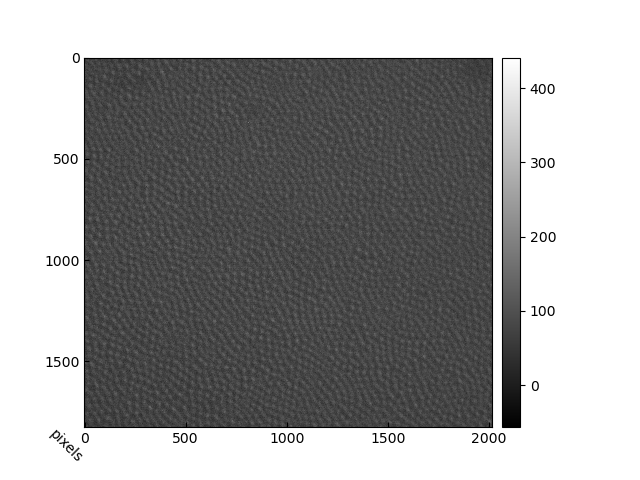

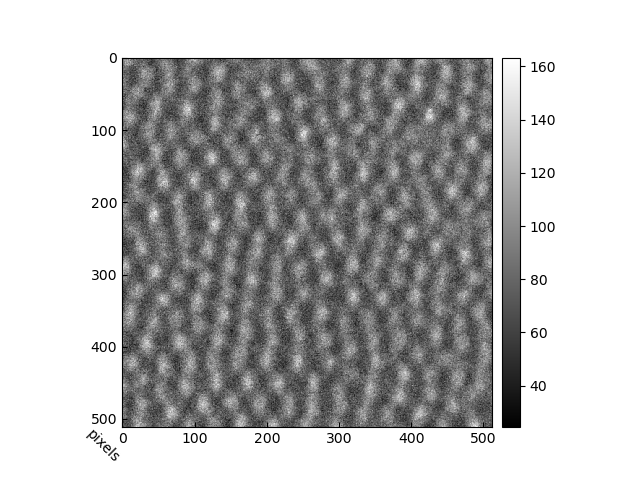

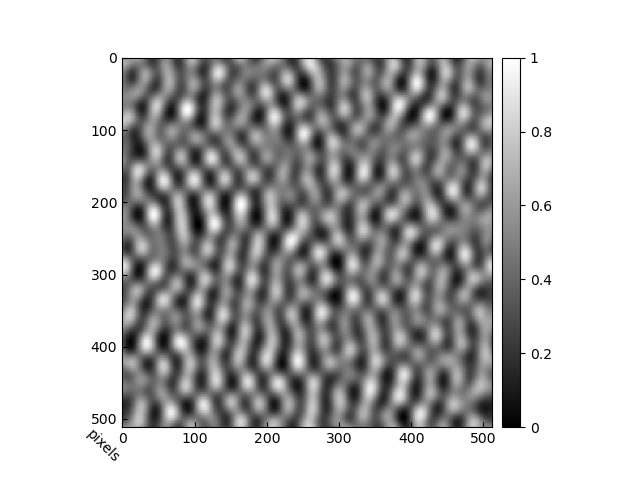

Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}
Unhandled message type set_device_pixel_ratio. {'device_pixel_ratio': 2, 'type': 'set_device_pixel_ratio'}


In [12]:
test_f = Path("/home/bendera/Lorentz_folder/AlecBender/mumax_training_files/SkyrmNet-main/Skyrm_testing_kit/experimental_data/FGT20210921_df-8mm_Tx-22.6_Ty0_B500G_cooling_0019_190.0K.tif"
          ).expanduser().resolve()

test_im = io.imread(test_f)
show_im(test_im)
tilt_dir = 55.23-90 # tilt axis
test_im = ndi.rotate(test_im, tilt_dir)
test_im = center_crop_im(test_im, (1024,1024))
test_im = center_crop_im(test_im, (512,512))

filt, bkg = filter_background(test_im, ret_bkg=True, filter_lf=150, filter_hf=80)

show_im(test_im)
show_im(filt)

/home/bendera/enter/envs/PyLorentz/lib/python3.7/site-packages/skimage/filters/thresholding.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  sharex=True, sharey=True)


skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


/home/bendera/enter/envs/PyLorentz/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_isodata
skimage.

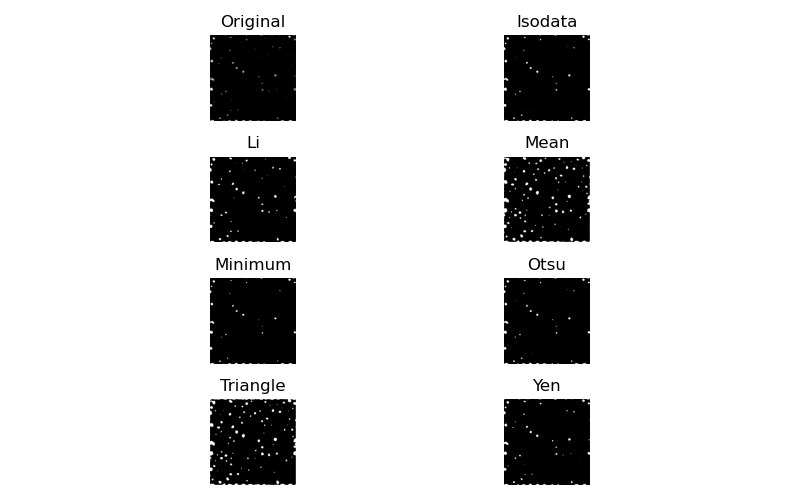

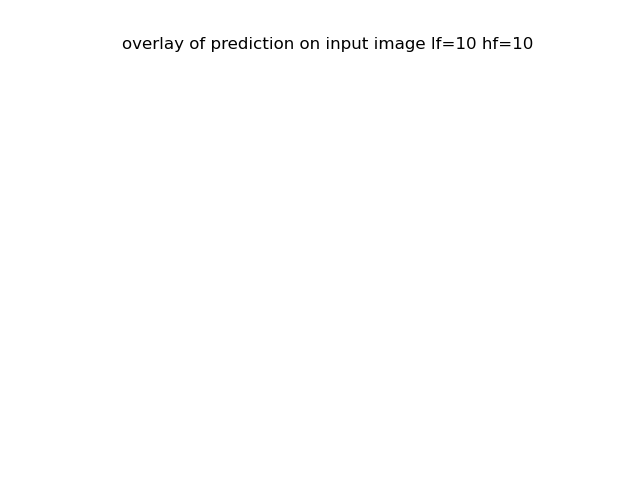

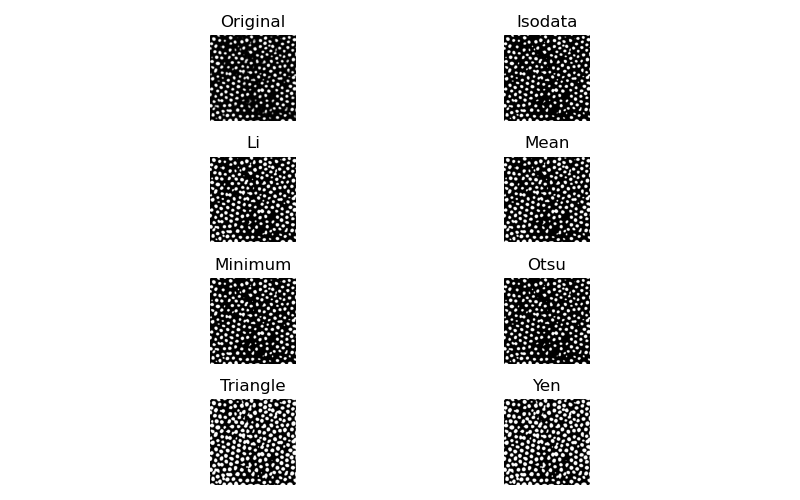

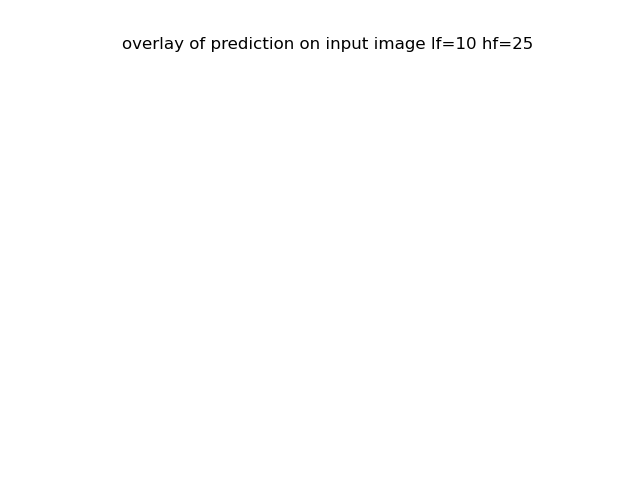

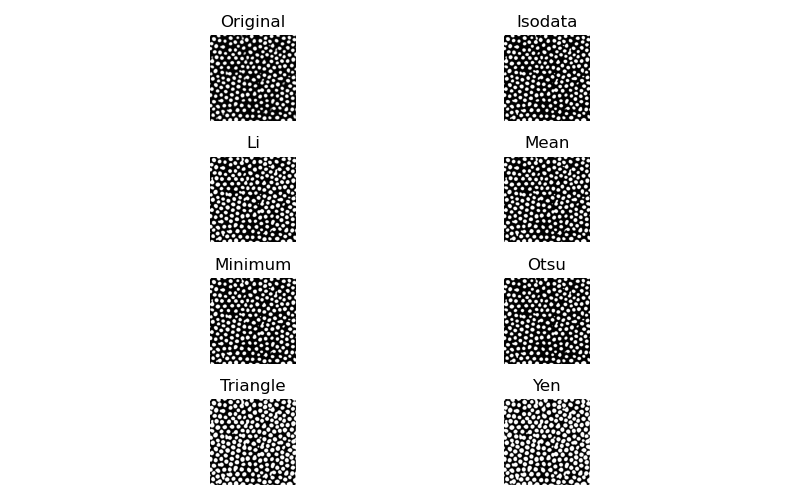

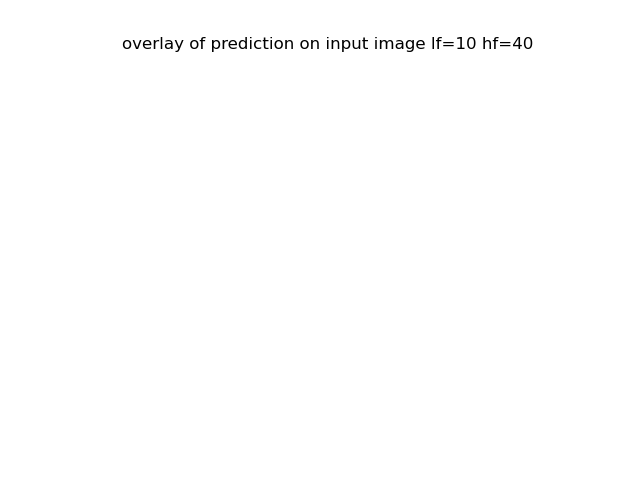

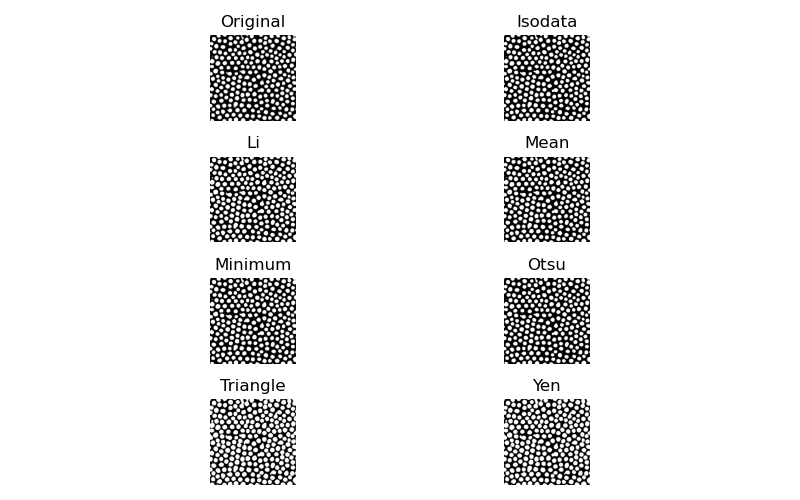

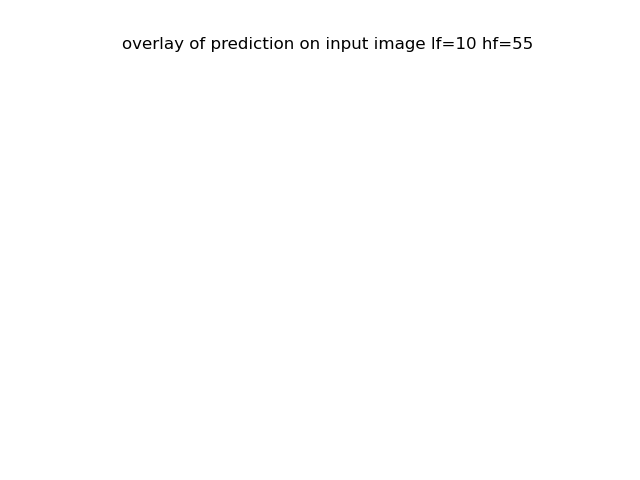

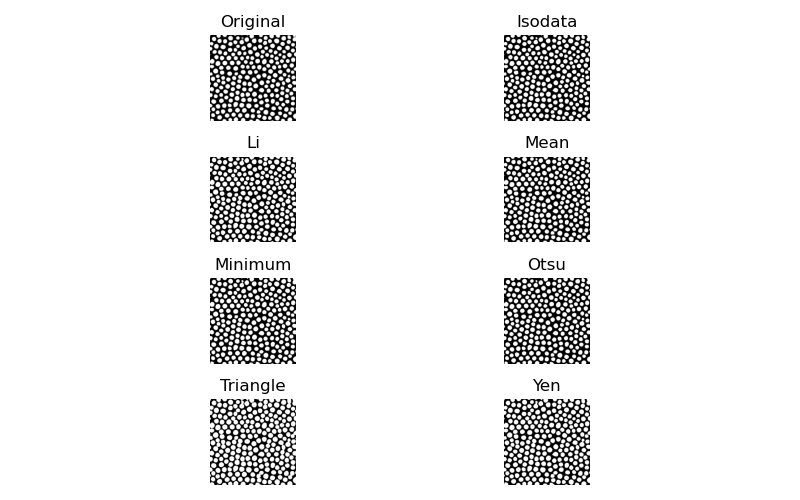

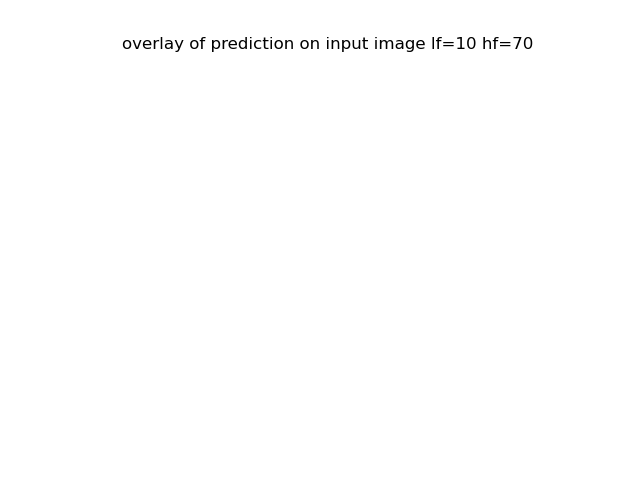

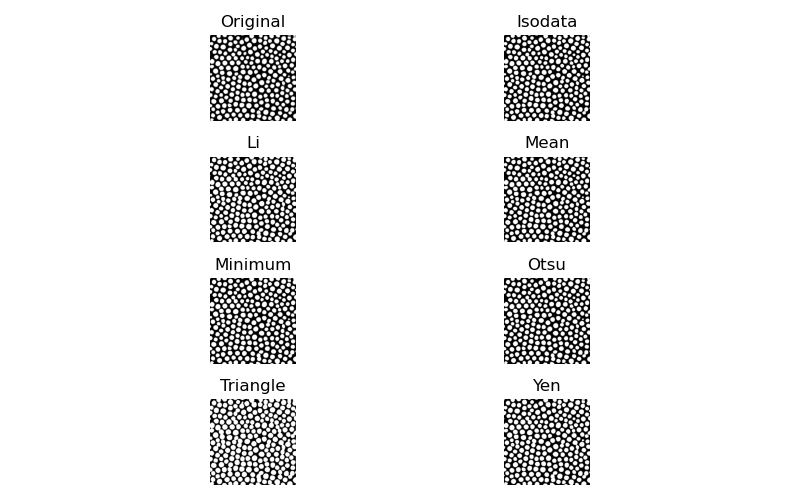

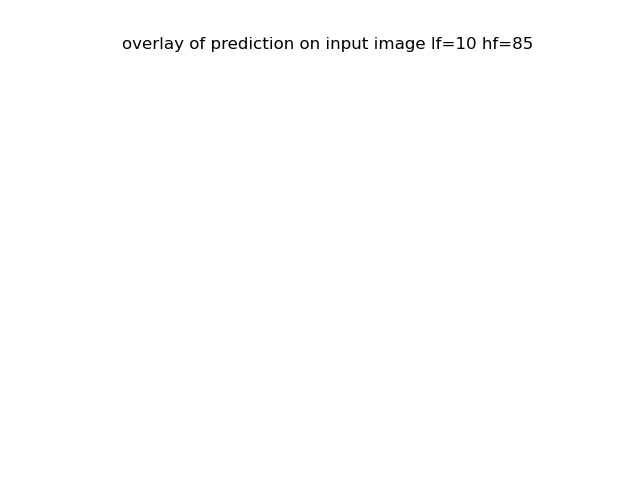

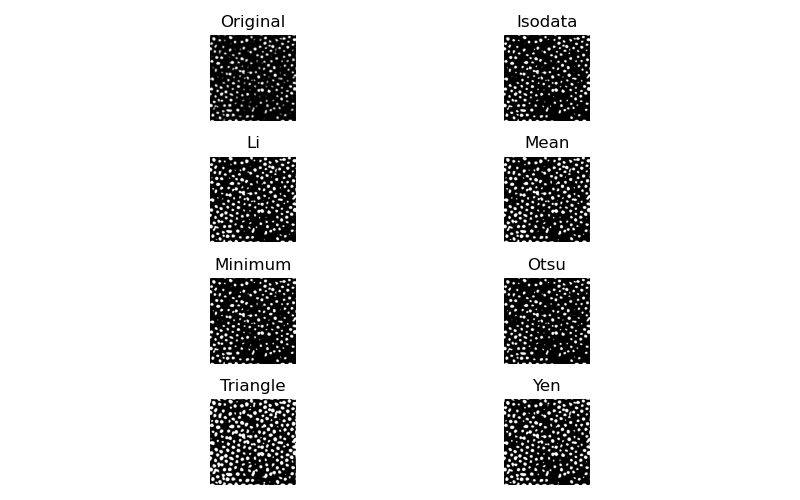

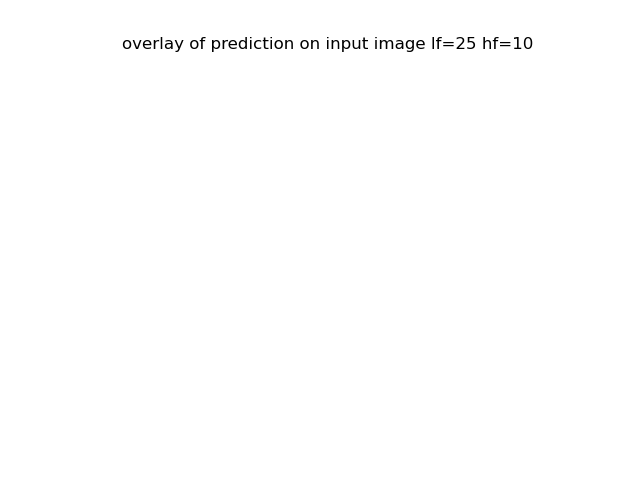

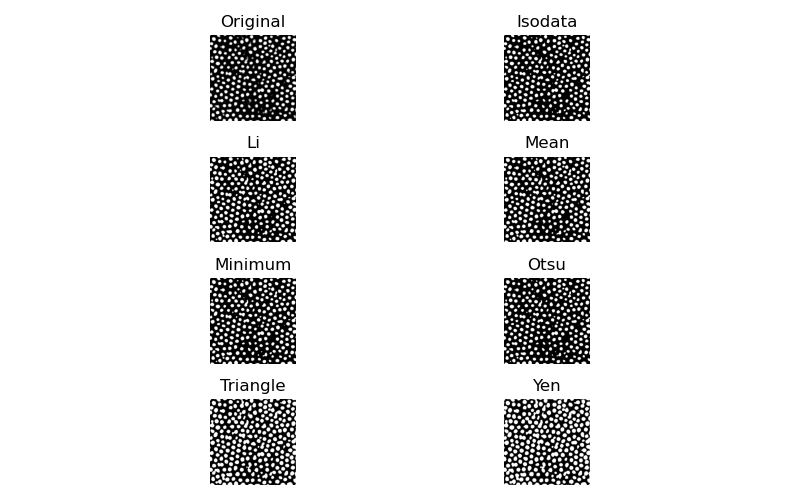

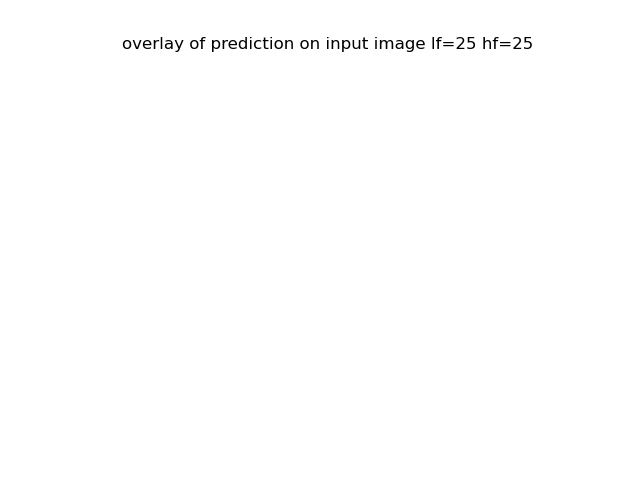

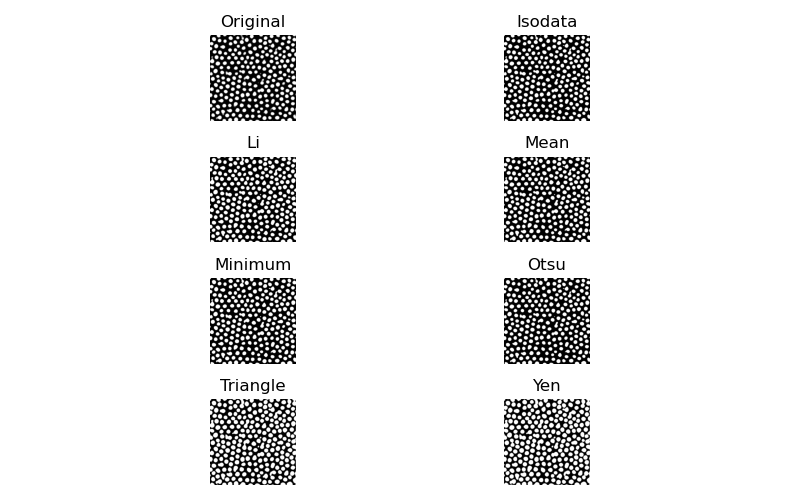

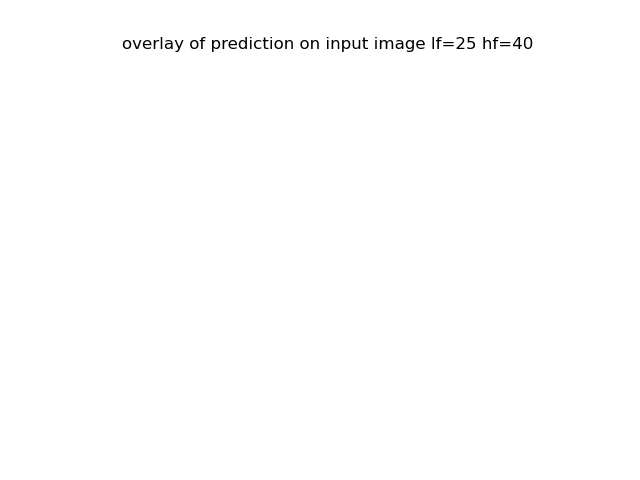

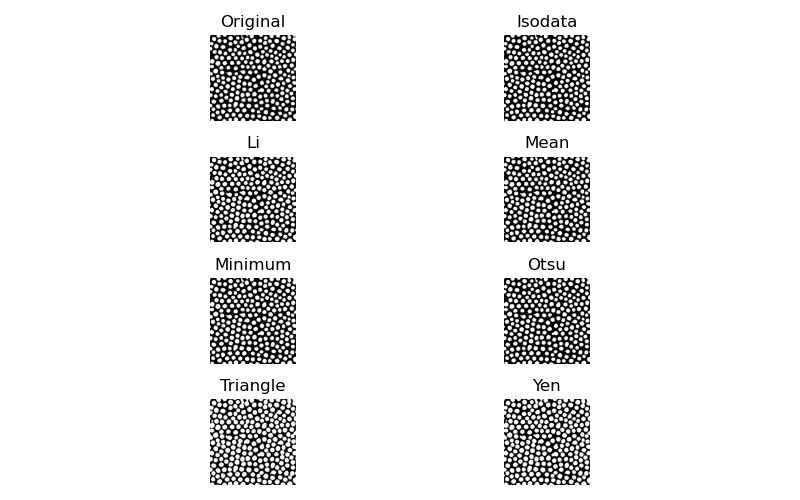

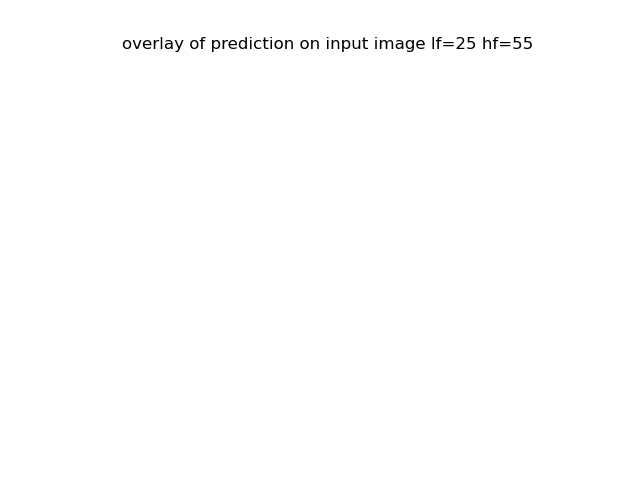

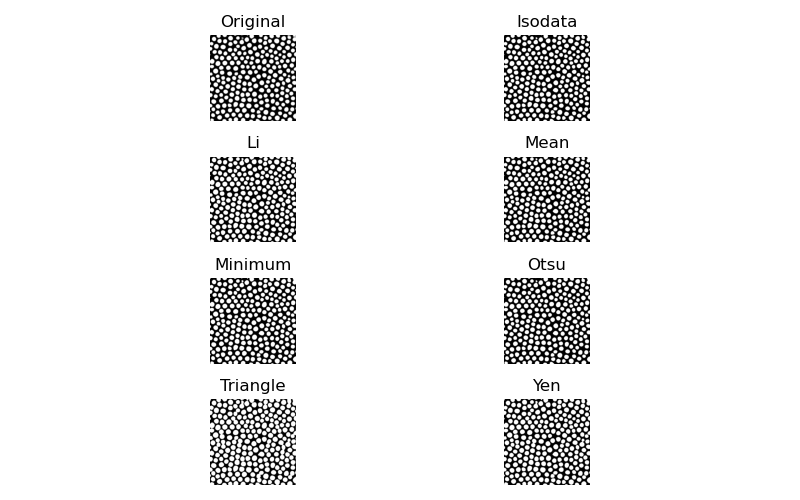

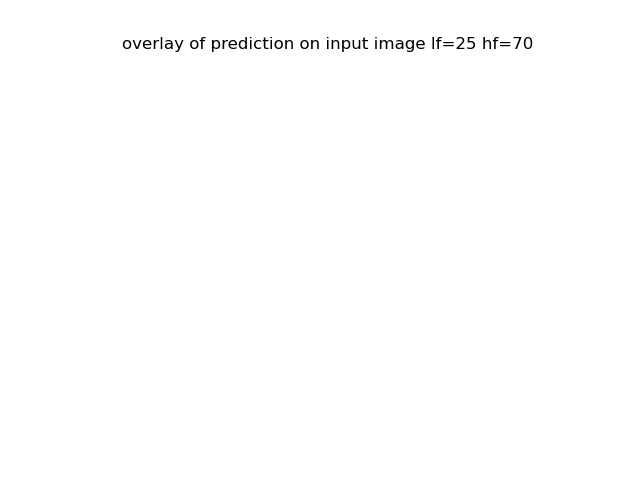

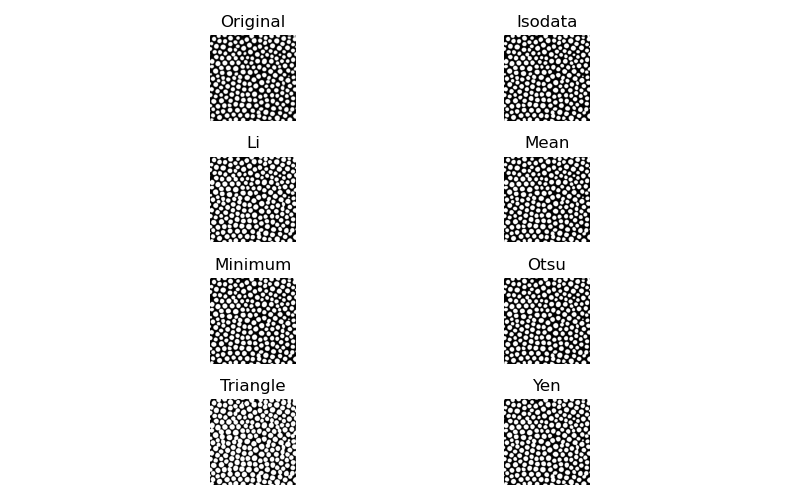

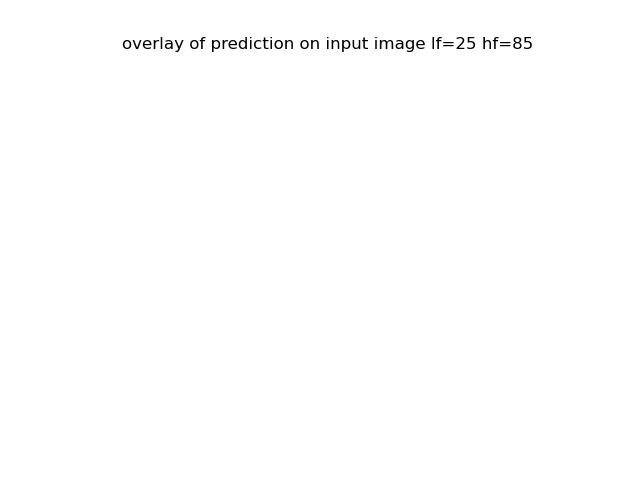

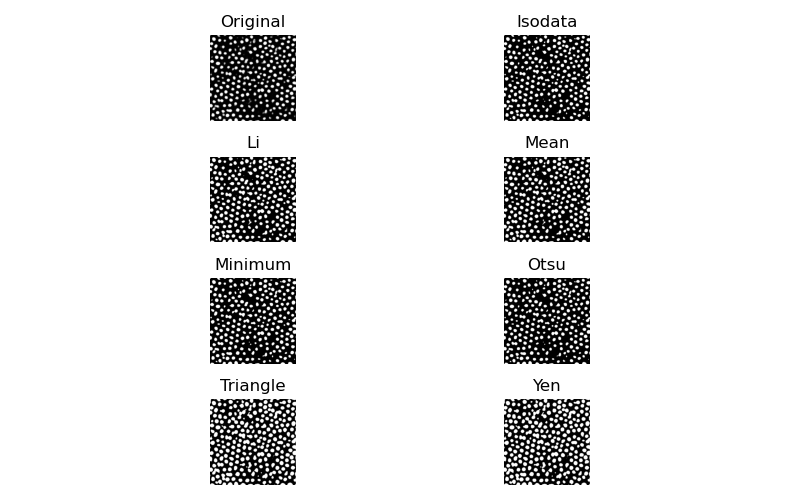

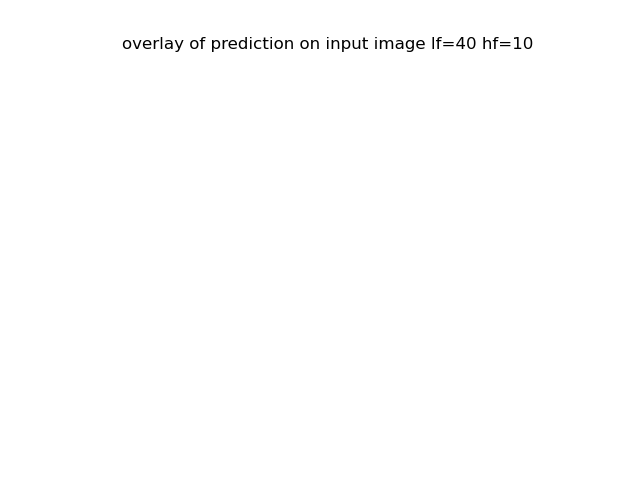

In [11]:
test_f = Path("/home/bendera/Lorentz_folder/AlecBender/mumax_training_files/SkyrmNet-main/Skyrm_testing_kit/experimental_data/FGT20210921_df-8mm_Tx-22.6_Ty0_B500G_cooling_0019_190.0K.tif"
          ).expanduser().resolve()

test_im = io.imread(test_f)
tilt_dir = 55.23-90 # tilt axis
test_im = ndi.rotate(test_im, tilt_dir)
test_im = center_crop_im(test_im, (1024,1024))
test_im = center_crop_im(test_im, (512,512))

#filter_lf_num = 80
#filter_hf_num = 60

for filter_lf_num in range(10, 91, 15):
    for filter_hf_num in range(10, 91, 15):

        filt, bkg = filter_background(test_im, ret_bkg=True, filter_lf=filter_lf_num, filter_hf=filter_hf_num)

        #show_im(filt, "skyrmion input image (experimental)")

        thresh = 0.98
        prediction = segment_im(filt, model)
        #show_im(prediction[0,:,:,1], 'prediction')
        output = thresholding(prediction[0,:,:,1], thresh)
        #show_im(output, 'CNN prediction. 1=skyrmion, 0=background')
        fig, ax = plt.subplots()
        #ax.matshow(test_im, cmap='gray')
        # ax.matshow(1-output, alpha=1, cmap='Reds')
        #ax.matshow(filt*output, cmap='gray')
        #ax.matshow(filt, cmap='gray')
        ax.set_title(f"overlay of prediction on input image lf={filter_lf_num} hf={filter_hf_num}")
        plt.axis('off')
        #plt.show()

# Applying the NN to new images
if not training the NN, you should load it first (see top)

### Single Image

In [ ]:
test_f = "/home/bendera/Lorentz_folder/AlecBender/mumax_training_files/SkyrmNet-main/Skyrm_testing_kit/experimental_filter/FGT20210921_df-8mm_Tx-22.6_Ty0_B500G_cooling_0019_190.0K_1_filter.tif"

# test_im = np.load(test_f)
test_im = io.imread(test_f)
tilt_dir = 55.23-90 # tilt axis
test_im = ndi.rotate(test_im, tilt_dir)
test_im = center_crop_im(test_im, (1024,1024))
test_im = center_crop_im(test_im, (512,512))

# a, b = 325, 400
# dim = 512
# test_im = test_im[a:a+dim,b:b+dim]

# test_im = norm_image(test_im)
show_im(test_im, "skyrmion input image (experimental)")

In [6]:
def segment_im(input_image, NN): 
    # Convert to 4D tensor (required, even if it is a single image)
    # image = input_image[None, ...]
    image = input_image[np.newaxis, np.newaxis, ...]
    # Convert to pytorch format and move to GPU
    image_ = torch.from_numpy(image).float().cuda(gpu)
    # make a prediction
    prediction = model.forward(image_)
    prediction = F.softmax(prediction, dim=1).cpu().detach().numpy()
    prediction = np.transpose(prediction, [0, 2, 3, 1]) # rearange dimensions for plotting
    return prediction

In [10]:
def thresholding (mz, thresh):
    thresh_triangle = threshold_triangle(mz)
    truth = np.where(mz < thresh_triangle, 0, 1)
    truth = (truth).astype('uint8')

    mu = skimage.filters.try_all_threshold(mz)
    show_im(mu)

    '''
    fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(mz, cmap=plt.cm.gray)
    ax[0].set_title('original')
    ax[0].axis('off')

    ax[1].hist(mz.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(truth, cmap=plt.cm.gray)
    ax[2].set_title('truth')
    ax[2].axis('off')

    plt.show()
    '''
        
    return truth

In [ ]:
#filt, bkg = filter_background(test_im, ret_bkg=True)

In [ ]:
thresh = 0.98
prediction = segment_im(filt, model)
show_im(prediction[0,:,:,1], 'prediction')
output = thresholding(prediction[0,:,:,1], thresh)
show_im(output, 'CNN prediction. 1=skyrmion, 0=background')

In [ ]:
fig, ax = plt.subplots()
# ax.matshow(test_im, cmap='gray')
# ax.matshow(1-output, alpha=1, cmap='Reds')
ax.matshow(filt*output, cmap='gray')
ax.set_title("overlay of prediction on input image")
plt.axis('off')
plt.show()

In [ ]:
### this is the output of the NN, the prediction 
### It's not integers/classes yet, it's a stack of images where the last dimension is channels
### and each channel corresponds to the NNs liklihood (not scaled) that the pixel corresponds to that channel
pfull = np.zeros_like(prediction[0,:,:,0])
for i in range(prediction.shape[-1]):
    pfull += prediction[0,:,:,i]*i

show_im(pfull, title="1 = background, 2 = skyrmion")

## Multiple Images

In [ ]:
def segment_im(input_image, NN): 
    # Convert to 4D tensor (required, even if it is a single image)
    # image = input_image[None, ...]
    image = input_image[np.newaxis, np.newaxis, ...]
    # Convert to pytorch format and move to GPU
    image_ = torch.from_numpy(image).float().cuda(gpu)
    # make a prediction
    prediction = model.forward(image_)
    prediction = F.softmax(prediction, dim=1).cpu().detach().numpy()
    prediction = np.transpose(prediction, [0, 2, 3, 1]) # rearange dimensions for plotting
    return prediction

In [ ]:
def thresholding (mz, thresh):
    thresh_triangle = threshold_triangle(mz)
    truth = np.where(mz < thresh_triangle, 0, 1)
    truth = (truth).astype('uint8')

    fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(mz, cmap=plt.cm.gray)
    ax[0].set_title('original')
    ax[0].axis('off')

    ax[1].hist(mz.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(thresh, color='r')

    ax[2].imshow(truth, cmap=plt.cm.gray)
    ax[2].set_title('truth')
    ax[2].axis('off')

    plt.show()
        
    return truth

In [ ]:
test_fdir = "/zota/Lorentz/AlecBender/from_Arthur/exp_data/FGT/2021_09_28/FC_B500_2"

test_f = glob.glob(f'{test_fdir}/*.tif')
test_f.sort()

i = 1
tot = len(test_f)
for tif in test_f:
    if i % 100 == 0: 
        print(f"{i}/{tot}", end="\r")
    test_im = io.imread(tif)
    tilt_dir = 55.23-90 # tilt axis
    test_im = ndi.rotate(test_im, tilt_dir)
    test_im = center_crop_im(test_im, (1024,1024))
    test_im = center_crop_im(test_im, (512,512))
    show_im(test_im, "skyrmion input image (experimental)")
    filt, bkg = filter_background(test_im, ret_bkg=True)
    thresh = 0.98
    prediction = segment_im(filt, model)
    show_im(prediction[0,:,:,1], 'prediction')
    output = thresholding(prediction[0,:,:,1], thresh)
    show_im(output, 'CNN prediction. 1=skyrmion, 0=background')
    fig, ax = plt.subplots()
    # ax.matshow(test_im, cmap='gray')
    # ax.matshow(1-output, alpha=1, cmap='Reds')
    ax.matshow(filt*output, cmap='gray')
    ax.set_title("overlay of prediction on input image")
    plt.axis('off')
    plt.show()